# 5 giả thuyết
- Nhiệt độ trung bình toàn cầu tăng cao hơn từ 2020 đến nay
- Nhiệt độ bán cầu bắc nóng hơn bán cầu nam
- Các thành phố gần biển có nhiệt độ trung bình thấp hơn, tốc độ gió cao hơn so với các thành phố sâu trong đất liền.
- Mùa hè nhiều mưa bão nhất
- Sáng sớm (0h-6h) lạnh hơn so với buổi tối(18h-23h59)

# Khai báo thư viện

In [1]:
!pip install cartopy
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=941692125717ccda3ca1a1aff45fad6c9589e1eddb0d402e1e4612b078bdb065
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [2]:
import pandas as pd
import numpy as np
import datetime
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.functions import to_timestamp, lit, min, max, col, when, count, avg, mean, month, year, hour, extract

# Đọc dữ liệu

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
spark = SparkSession.builder.appName("BigData").getOrCreate()

In [6]:
path = "/content/drive/MyDrive/Code/Hoctap/K1N3/BigData/BTL2/"
city_df = spark.read.csv(path+"cities.csv", header=True, inferSchema=True)

In [7]:
df = spark.read.csv(path+"data_cleaned.csv", header=True, inferSchema=True)

# 1: Nhiệt độ trung bình toàn cầu tăng cao hơn từ 2020 đến nay
Nhiệt độ trung bình toàn cầu được đo bằng nhiệt độ thực tế (temperature_2m) chứ không phải nhiệt độ cảm nhận (apparent_temperature)

In [8]:
time2020 = datetime.datetime(2020, 1, 1)
print(time2020)

2020-01-01 00:00:00


In [9]:
min_time = df.select(min('time')).first()[0]
max_time = df.select(max('time')).first()[0]

print("Thời gian bắt đầu của dữ liệu", min_time)
print("Thời gian kết thúc của dữ liệu", max_time)

Thời gian bắt đầu của dữ liệu 2019-01-01 00:00:00
Thời gian kết thúc của dữ liệu 2023-08-01 23:00:00


Để chính xác hơn, chỉ cần kiểm tra đến 01/01/2023. Bởi đến 01/08/2023 vẫn chưa phải mùa đông. Mùa đông nhiệt độ thấp hơn sẽ khiến nhiệt độ trung bình sẽ giảm xuống 1 chút.

In [11]:
time2023 = datetime.datetime(2023, 1, 1)
temp_before_2020 = df.filter(df['time'] < time2020).select('temperature_2m')
temp_after_2020 = df.filter((df['time'] >= time2020) & (df['time'] <= time2023)).select('temperature_2m')

In [12]:
mean_temp_before_2020 = temp_before_2020.agg(F.mean('temperature_2m')).collect()[0][0]
mean_temp_after_2020 = temp_after_2020.agg(F.mean('temperature_2m')).collect()[0][0]
print("Nhiệt độ trung bình từ 01-01-2019 đến 01-01-2020: ", mean_temp_before_2020)
print("Nhiệt độ trung bình từ 01-01-2020 đến 01-01-2023: ", mean_temp_after_2020)

Nhiệt độ trung bình từ 01-01-2019 đến 01-01-2020:  20.04526817611852
Nhiệt độ trung bình từ 01-01-2020 đến 01-01-2023:  19.893404788190878


Nhiệt độ trung bình sau năm 2020 thấp hơn trước năm 2020. Giả thuyết có thể sai.

Ngoài ra 2 nhiệt độ đều cao hơn so với nhiệt độ trung bình toàn cầu thực tế bởi chưa có dữ liệu của các vùng xung quanh vòng cực 2 bán cầu.



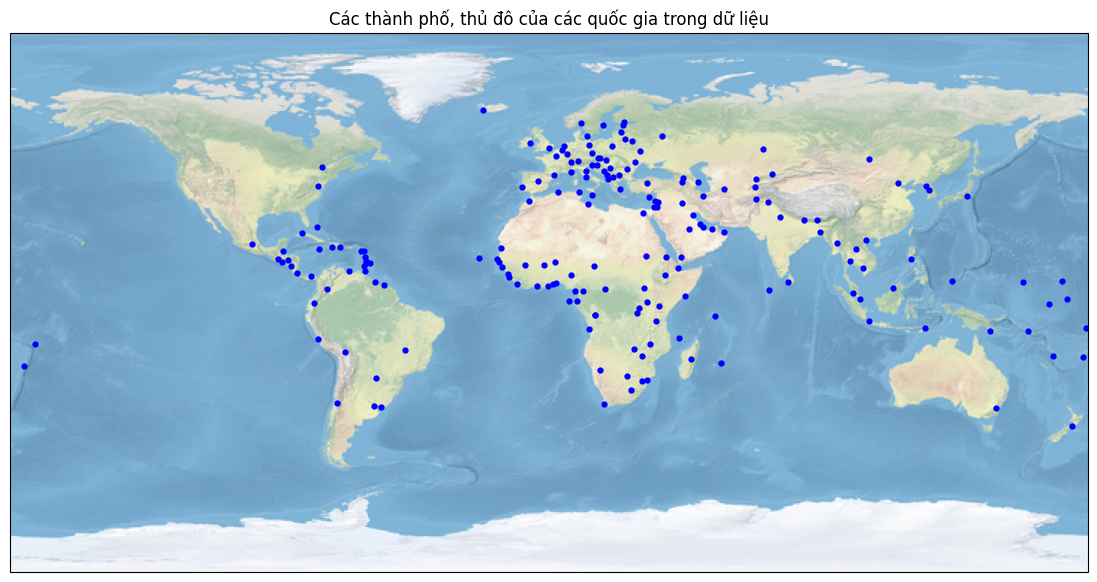

In [13]:
fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()

for row in city_df.collect():
    lon, lat = row["Longitude"], row["Latitude"]
    plt.plot(lon, lat, 'bo', markersize=3.5, transform=ccrs.Geodetic())

plt.title("Các thành phố, thủ đô của các quốc gia trong dữ liệu")
plt.show()

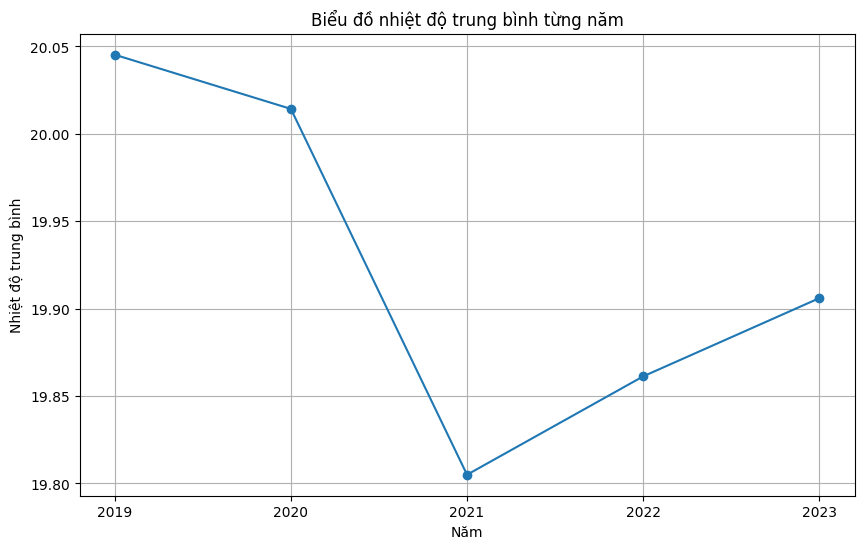

In [14]:
pandasdf = df.groupBy(year('time').alias('year')).agg(mean('temperature_2m').alias('mean_temperature')).toPandas()
pandasdf = pandasdf.sort_values(by='year')
plt.figure(figsize=(10, 6))
plt.plot(pandasdf['year'], pandasdf['mean_temperature'], linestyle='-', marker='o')
plt.xlabel('Năm')
plt.xticks(pandasdf['year'])
plt.ylabel('Nhiệt độ trung bình')
plt.title('Biểu đồ nhiệt độ trung bình từng năm')
plt.grid()
plt.show()

Biểu đồ có xu hướng giảm từ năm 2020 trở đi và có xu hướng tăng trở lại

**Theo [NASA](https://climate.nasa.gov/vital-signs/global-temperature/), biểu đồ dưới đây cho thấy sự thay đổi về nhiệt độ bề mặt trung bình toàn cầu so với mức trung bình dài hạn từ năm 1951 đến năm 1980**

![Hello](https://lh3.googleusercontent.com/u/0/drive-viewer/AK7aPaCpFIxM8DCcwb8qcW5RFww0WQFP7WNs-VRYeCwbjwGYrHDHR92DU4-ZqP8oGSAXR_h_wHxr-369UZWSmp0TwPrzNCNwTw=w1912-h958)

Có thể giải thích bởi sự hoạt động công nghiệp, phương tiện giao thông chững lại do dịch Covid 19. Lượng khí thải giảm mạnh khiến nhiệt độ trung bình giảm đi một chút so với năm 2020.

**KẾT LUẬN: GIẢ THUYẾT 1 SAI**

# 2: Nhiệt độ bán cầu bắc nóng hơn bán cầu nam
Cảm giác nóng lạnh dựa trên nhiệt độ cảm nhận sẽ chính xác hơn

In [15]:
cities_N = city_df.filter(city_df['Latitude'] >= 0)
cities_S = city_df.filter(city_df['Latitude'] < 0)

count_cities_N = cities_N.count()
count_cities_S = cities_S.count()

count_cities_N, count_cities_S

(153, 40)

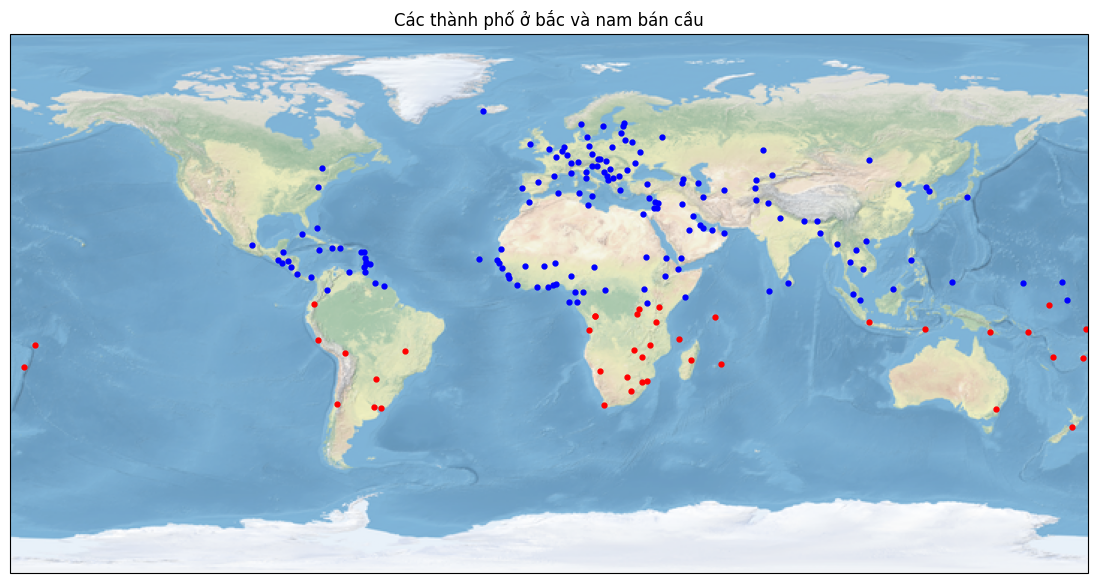

In [16]:
cities_N_pd = cities_N.toPandas()
cities_S_pd = cities_S.toPandas()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()

for index, row in cities_N_pd.iterrows():
    lon, lat = row['Longitude'], row['Latitude']
    plt.plot(lon, lat, 'bo', markersize=3.5, transform=ccrs.Geodetic())

for index, row in cities_S_pd.iterrows():
    lon, lat = row['Longitude'], row['Latitude']
    plt.plot(lon, lat, 'ro', markersize=3.5, transform=ccrs.Geodetic())

plt.title("Các thành phố ở bắc và nam bán cầu")
plt.show()

Số thành phố ở Bắc bán cầu gấp gần 4 lần số thành phố ở Nam bán cầu.

In [17]:
cities_N_capitals = cities_N.select('Capital')
cities_S_capitals = cities_S.select('Capital')

In [18]:
lat_N = df.join(cities_N_capitals, df['City'] == cities_N_capitals['Capital'], 'inner') \
    .select(df['apparent_temperature'])

lat_S = df.join(cities_S_capitals, df['City'] == cities_S_capitals['Capital'], 'inner') \
    .select(df['apparent_temperature'])

In [19]:
mean_lat_N = lat_N.agg(F.mean('apparent_temperature')).collect()[0][0]
mean_lat_S = lat_S.agg(F.mean('apparent_temperature')).collect()[0][0]

print(f"Nhiệt độ cảm nhận trung bình ở Bắc bán cầu: {mean_lat_N}")
print(f"Nhiệt độ cảm nhận trung bình ở Nam bán cầu: {mean_lat_S}")

Nhiệt độ cảm nhận trung bình ở Bắc bán cầu: 19.895757344156046
Nhiệt độ cảm nhận trung bình ở Nam bán cầu: 22.386031834926456


In [20]:
min_latitude = city_df.agg(min(city_df['Latitude'])).collect()[0][0]
max_latitude = city_df.agg(max(city_df['Latitude'])).collect()[0][0]

min_latitude, max_latitude

(-41.2866, 64.1355)

Giải thích: Do hầu hết lục địa tập trung về Bắc bán cầu, vì vậy dân cư chủ yếu tập trung ở Bắc bán cầu nhiều hơn. Vì vậy các thành phố cũng nhiều hơn so với phía Nam. Từ bản đồ, các thành phố gần cực Nam rất ít. Vì vậy ảnh hưởng nhiều đến nhiệt độ trung bình giữa các thành phố ở 2 bán cầu.

KẾT LUẬN: GIẢ THUYẾT SAI

# 3: Các thành phố gần biển có nhiệt độ trung bình thấp hơn, tốc độ gió cao hơn so với các thành phố sâu trong đất liền.

In [21]:
cities = spark.read.csv(path + "cities.csv", header=True, inferSchema=True)
cities.show(5)


+-----------+--------+---------+----------------+---------+---+
|    Country|Latitude|Longitude|         Capital|elevation|dis|
+-----------+--------+---------+----------------+---------+---+
|Afghanistan| 34.5289|  69.1725|           Kabul|     1800|  0|
|    Albania| 41.3275|  19.8189|          Tirane|      110|  1|
|    Algeria| 36.7525|    3.042|         Algiers|      186|  1|
|    Andorra| 42.5078|   1.5211|Andorra la Vella|     1045|  0|
|     Angola| -8.8368|  13.2343|          Luanda|       75|  1|
+-----------+--------+---------+----------------+---------+---+
only showing top 5 rows



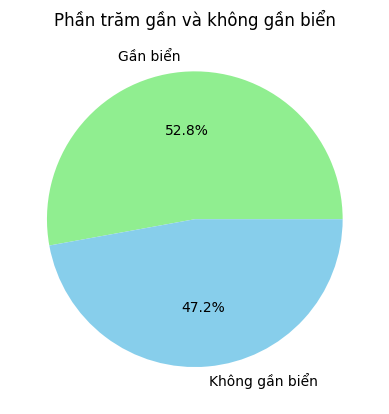

In [22]:
ct_sea = cities.groupBy('dis').count()

ct_sea_pd = ct_sea.toPandas()

labels = ['Gần biển', 'Không gần biển']
sizes = ct_sea_pd['count']
colors = ['lightgreen', 'skyblue']

plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
plt.title("Phần trăm gần và không gần biển")
plt.show()

Các thành phố đều giáp biển nhiều hơn 1 chút

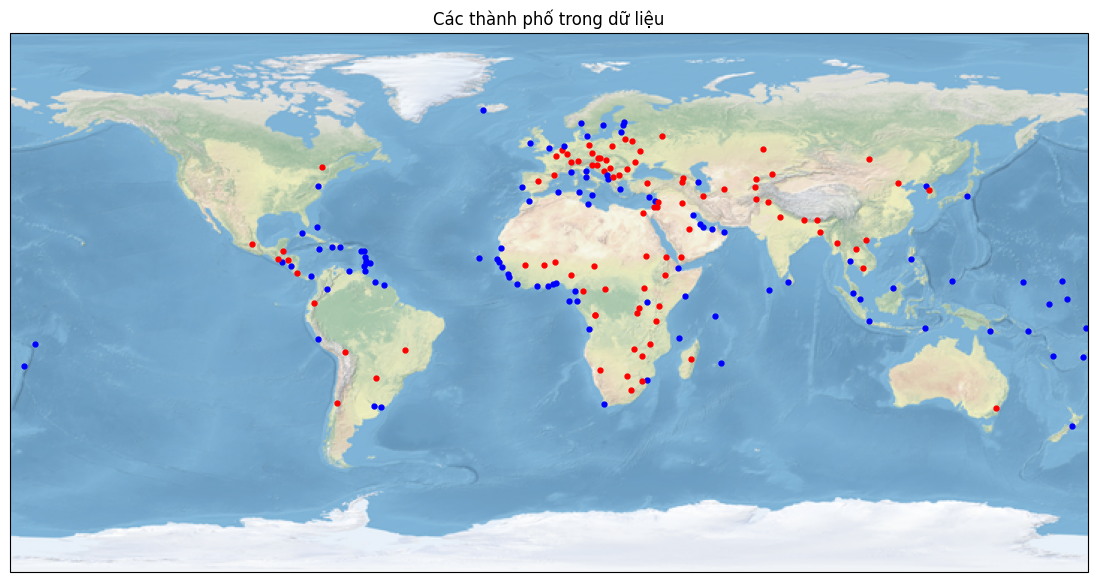

In [23]:
cities_pd = cities.toPandas()

fig = plt.figure(figsize=(14, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.stock_img()

for index, row in cities_pd.iterrows():
    lon, lat, cl = row['Longitude'], row['Latitude'], row['dis']
    s = 'bo' if cl else 'ro'
    plt.plot(lon, lat, s, markersize=3.5, transform=ccrs.Geodetic())

plt.title("Các thành phố trong dữ liệu")
plt.show()

Xanh là gần biển, đỏ là không gần

## So sánh nhiệt độ trung bình

In [27]:
cities_1 = cities.filter(cities['dis'] == 1)
cities_0 = cities.filter(cities['dis'] == 0)

In [28]:
avg_temp_1 = df.join(cities_1, df['City'] == cities_1['Capital'], 'inner') \
    .agg(mean(df['temperature_2m']).alias('avg_temperature')).collect()[0]['avg_temperature']
avg_temp_0 = df.join(cities_0, df['City'] == cities_0['Capital'], 'inner') \
    .agg(mean(df['temperature_2m']).alias('avg_temperature')).collect()[0]['avg_temperature']

print(f"Nhiệt độ trung bình các thành phố gần/giáp biển: {avg_temp_1}")
print(f"Nhiệt độ trung bình các thành phố không gần biển: {avg_temp_0}")

Nhiệt độ trung bình các thành phố gần/giáp biển: 22.38626086884349
Nhiệt độ trung bình các thành phố không gần biển: 17.17307443402867


Nhiệt độ trung bình các thành phố gần/ giáp biển ấm hơn so với các thành phố sâu trong đất liền.

Giải thích: Do các vùng biển có các dòng hải lưu. Các dòng hải lưu có ảnh hưởng đáng kể đến nhiệt độ của các thành phố gần biển và là một yếu tố quan trọng trong việc làm cho các khu vực này có nhiệt độ ấm hơn. Vì vậy giúp biên độ nhiệt không thay đổi mạnh bằng các thành phố sâu trong đất liền

**Vậy giả thuyết sai 1 phần**

## So sánh tốc độ gió trung bình

In [29]:
avg_wind_1 = df.join(cities_1, df['City'] == cities_1['Capital'], 'inner') \
    .agg(mean(df['windspeed_10m']).alias('avg_windspeed')).collect()[0]['avg_windspeed']
avg_wind_0 = df.join(cities_0, df['City'] == cities_0['Capital'], 'inner') \
    .agg(mean(df['windspeed_10m']).alias('avg_windspeed')).collect()[0]['avg_windspeed']

print(f"Tốc độ gió trung bình các thành phố gần/giáp biển: {avg_wind_1}")
print(f"Tốc độ gió trung bình các thành phố không gần biển: {avg_wind_0}")

Tốc độ gió trung bình các thành phố gần/giáp biển: 13.704571307814339
Tốc độ gió trung bình các thành phố không gần biển: 8.833183087819767


Tốc độ gió các thành phố gần biển cao hơn.

Giải thích: Do yếu tố địa hình. Các thành phố gần biển không phải chịu ảnh hưởng của núi cao chặn gió nên tốc độ gió gần biển sẽ cao hơn trong đất liền.

**Vậy giả thuyết đúng 1 phần**

KẾT LUẬN: Giả thuyết đúng phần tốc độ gió nhưng sai về phần nhiệt độ

# 4: Mùa hè nhiều mưa, bão nhất
- Dựa trên thời tiết, tổng lượng mưa và tốc độ gió

In [30]:
df = df.withColumn('month', month(df['time']))
spring = df.filter(col('month') >= 3).filter(col('month') < 6)
summer = df.filter(col('month') >= 6).filter(col('month') < 9)
fall = df.filter(col('month') >= 9).filter(col('month') < 12)
winter = df.filter(col('month') >= 12).union(df.filter(col('month') < 3))

spring_cnt = spring.filter(~spring['weathercode'].isin([0, 1, 2, 3, 71])).groupBy('weathercode').count()
summer_cnt = summer.filter(~summer['weathercode'].isin([0, 1, 2, 3, 71])).groupBy('weathercode').count()
fall_cnt = fall.filter(~fall['weathercode'].isin([0, 1, 2, 3, 71])).groupBy('weathercode').count()
winter_cnt = winter.filter(~winter['weathercode'].isin([0, 1, 2, 3, 71])).groupBy('weathercode').count()

In [31]:
total_counts = spring_cnt.union(summer_cnt).union(fall_cnt).union(winter_cnt)
total_counts = total_counts.groupBy('weathercode').sum('count')

spring_counts = spring_cnt.join(total_counts, 'weathercode', 'inner')
spring_counts = spring_counts.withColumn('percentage', spring_counts['count'] / spring_counts['sum(count)'])

summer_counts = summer_cnt.join(total_counts, 'weathercode', 'inner')
summer_counts = summer_counts.withColumn('percentage', summer_counts['count'] / summer_counts['sum(count)'])

fall_counts = fall_cnt.join(total_counts, 'weathercode', 'inner')
fall_counts = fall_counts.withColumn('percentage', fall_counts['count'] / fall_counts['sum(count)'])

winter_counts = winter_cnt.join(total_counts, 'weathercode', 'inner')
winter_counts = winter_counts.withColumn('percentage', winter_counts['count'] / winter_counts['sum(count)'])

In [32]:
spring_data = spring_counts.select('weathercode', 'percentage').collect()
summer_data = summer_counts.select('weathercode', 'percentage').collect()
fall_data = fall_counts.select('weathercode', 'percentage').collect()
winter_data = winter_counts.select('weathercode', 'percentage').collect()

In [33]:
spring_lst = [row.percentage for row in spring_data]
summer_lst = [row.percentage for row in summer_data]
fall_lst = [row.percentage for row in fall_data]
winter_lst = [row.percentage for row in winter_data]

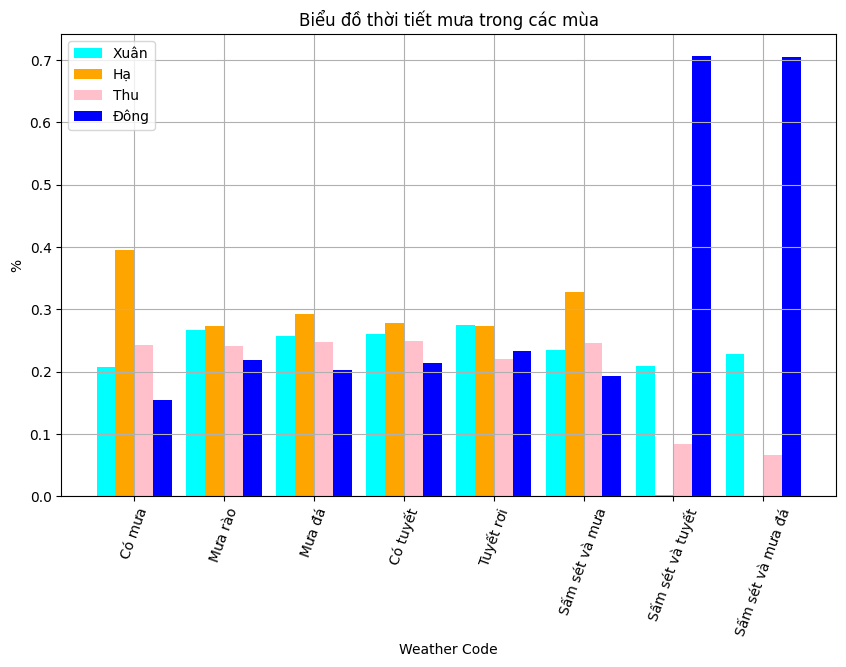

In [34]:
weather = ["Có mưa", "Mưa rào", "Mưa đá", "Có tuyết", "Tuyết rơi", "Sấm sét và mưa", "Sấm sét và tuyết", "Sấm sét và mưa đá"]
x_axis = range(len(weather))

# Create the plot using Matplotlib
plt.figure(figsize=(10, 6))
width = 0.21

plt.bar([i - width * 1.5 for i in x_axis], spring_lst, width=width, label='Xuân', color='cyan')
plt.bar([i - width * 0.5 for i in x_axis], summer_lst, width=width, label='Hạ', color='orange')
plt.bar([i + width * 0.5 for i in x_axis], fall_lst, width=width, label='Thu', color='pink')
plt.bar([i + width * 1.5 for i in x_axis], winter_lst, width=width, label='Đông', color='blue')

plt.xlabel('Weather Code')
plt.ylabel('%')

plt.xticks(x_axis, weather, rotation=70)
plt.title("Biểu đồ thời tiết mưa trong các mùa")
plt.legend()
plt.grid()
plt.show()


Mùa hè vẫn có tuyết do một vài nơi gần cực. Mùa hè có nhiều mưa hơn các mùa khác.

Cần dựa vào lượng mưa để chính xác hơn.

In [35]:
pre_mean_by_month = df.groupBy(month('time').alias('month')) \
    .agg(mean('precipitation').alias('mean_precipitation'))

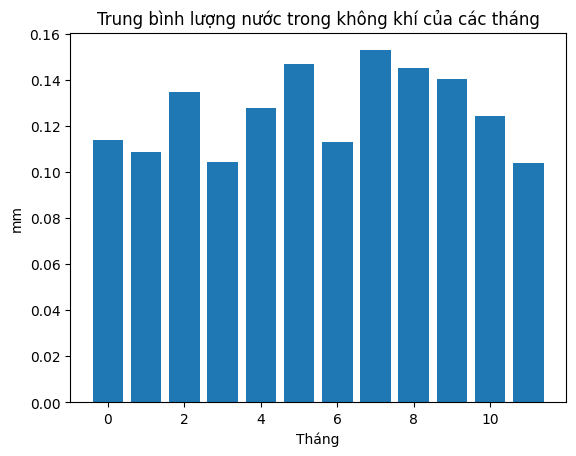

In [36]:
pre_mean_pandas = pre_mean_by_month.toPandas()

plt.bar(range(12), pre_mean_pandas['mean_precipitation'])
plt.xlabel("Tháng")
plt.ylabel("mm")
plt.title("Trung bình lượng nước trong không khí của các tháng")
plt.show()

Có thể thấy trong tháng 7-9 của mùa hè có lượng nước trong không khí nhiều hơn. Tức có lượng mưa nhiều hơn các tháng còn lại

In [37]:
# Gió cấp 8 - gió bão - 62km/h
df_wind8 = df.filter(df['windspeed_10m'] > 62)
df_wind8 = df_wind8.withColumn('month', month(df_wind8['time']))
cnt_wind8 = df_wind8.groupBy('month').count().orderBy('month')

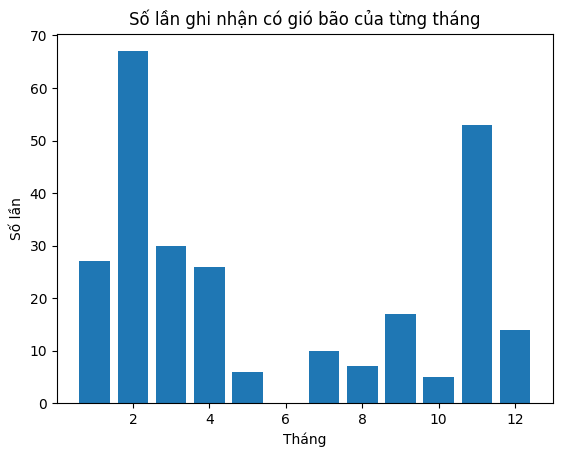

In [38]:
cnt_wind8_pandas = cnt_wind8.toPandas()

plt.bar(cnt_wind8_pandas['month'], cnt_wind8_pandas['count'])
plt.xlabel("Tháng")
plt.ylabel("Số lần")
plt.title("Số lần ghi nhận có gió bão của từng tháng")
plt.show()

Mùa hè ít gió mạnh hơn các mùa khác.
Trên thực tế, mùa bão thường kết thúc vào tháng 11. Vì vậy có thể thấy tháng 11 ghi nhận nhiều gió mạnh.

KẾT LUẬN: GIẢ THUYẾT MƯA ĐÚNG, GIẢ THUYẾT BÃO SAI

# 5: Sáng sớm (0h-6h) lạnh hơn so với buổi tối(18h-23h59)

In [39]:
df = df.withColumn("hour", hour(df['time']))
grouped_h = df.groupBy("hour")

In [40]:
mean_temp, max_temp, min_temp = [], [], []

In [41]:
result = grouped_h.agg(
    mean("apparent_temperature").alias("mean_temp"),
    max("apparent_temperature").alias("max_temp"),
    min("apparent_temperature").alias("min_temp")
).sort("hour")

In [42]:
result

DataFrame[hour: int, mean_temp: double, max_temp: double, min_temp: double]

In [43]:
hour_values = result.select("hour").rdd.flatMap(lambda x: x).collect()
mean_temp_values = result.select("mean_temp").rdd.flatMap(lambda x: x).collect()
max_temp_values = result.select("max_temp").rdd.flatMap(lambda x: x).collect()
min_temp_values = result.select("min_temp").rdd.flatMap(lambda x: x).collect()

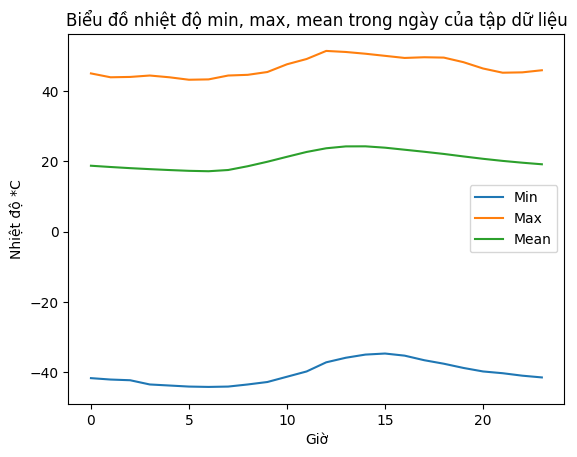

In [44]:
plt.plot(hour_values, min_temp_values, label="Min")
plt.plot(hour_values, max_temp_values, label="Max")
plt.plot(hour_values, mean_temp_values, label="Mean")

plt.xlabel("Giờ")
plt.ylabel("Nhiệt độ *C")
plt.title("Biểu đồ nhiệt độ min, max, mean trong ngày của tập dữ liệu")
plt.legend()
plt.show()

Có sự thay đổi về nhiệt độ trong ngày. Nhiệt độ xuống thấp nhất vào khoảng sáng sớm và tăng cao nhất vào chiều

In [45]:
atemp_S = df.filter((df['hour'] > 0) & (df['hour'] < 7)).agg(F.mean('apparent_temperature')).collect()[0][0]
atemp_T = df.filter((df['hour'] > 18) & (df['hour'] < 24)).agg(F.mean('apparent_temperature')).collect()[0][0]

In [46]:
print(f"Nhiệt độ trung bình vào sáng sớm (0h-6h): {atemp_S}")
print(f"Nhiệt độ trung bình vào tối (18h-24h): {atemp_T}")

Nhiệt độ trung bình vào sáng sớm (0h-6h): 17.69044545966674
Nhiệt độ trung bình vào tối (18h-24h): 20.18813149602893


Nhiệt độ trung bình vào buổi tối vẫn cao hơn vào sáng sớm.

Giải thích: Do nhiệt độ từ ánh sáng mặt trời. Buổi tối là thời điểm mặt trời mới lặn, nhiệt độ lúc này bắt đầu mới hạ dần. Còn vào sáng sớm, cách khoảng 6 tiếng sau khi mặt trời lặn, nhiệt độ lúc này đã hạ xuống mức thấp.

KẾT LUẬN: GIẢ THUYẾT ĐÚNG